In [1]:
import numpy as np
import pandas as pd
from river import optim
from river import metrics
from river.drift.binary import EDDM
from sail.telemetry import TracingClient
from sail.models.auto_ml.tune import SAILTuneGridSearchCV
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.models.river.linear_model import LogisticRegression
from sail.models.keras import KerasSequentialClassifier
from sail.models.auto_ml.auto_pipeline import SAILAutoPipeline
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
from sail.drift_detection.drift_detector import SAILDriftDetector
from sail.transformers.river.preprocessing import StandardScaler

#### Load Data


In [2]:
X = pd.read_csv("../../datasets/agrawal.csv").head(50000)

y = X["class"]
X.drop("class", axis=1, inplace=True)

#### Model Definition


In [3]:
logistic_reg = LogisticRegression(optimizer=optim.SGD(0.1))
random_forest = AdaptiveRandomForestClassifier(n_models=10)
keras = KerasSequentialClassifier(
    num_hidden_nodes=[10],
    hidden_layer_activation=["relu"],
    num_output_nodes=1,
    outer_layer_activation="sigmoid",
)

#### Create SAIL Pipeline


In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", "passthrough"),
]
sail_pipeline = SAILPipeline(
    steps=steps, scoring=[metrics.Accuracy], verbosity_level=1, verbosity_interval=1
)

#### HPO Params


In [5]:
params_grid = [
    {
        "classifier": [logistic_reg],
        "classifier__l2": [0.1, 0.9],
        "classifier__intercept_init": [0.2, 0.5],
    },
    {
        "classifier": [random_forest],
        "classifier__n_models": [5, 10],
        "Imputer": ["passthrough"],
    },
    {"classifier": [keras], "classifier__num_hidden_nodes": [[5], [10]]},
]

#### Create Model Instance


In [6]:
# tracer = TracingClient(service_name="SAIL_Testing", otlp_endpoint="http://localhost:4318")

auto_pipeline = SAILAutoPipeline(
    pipeline=sail_pipeline,
    pipeline_params_grid=params_grid,
    search_method=SAILTuneGridSearchCV,
    search_method_params={
        "num_cpus_per_trial": 1,
        "max_iters": 1,
        "early_stopping": False,
        "mode": "max",
        "scoring": "accuracy",
        "pipeline_auto_early_stop": False,
        "keep_best_configurations": 2,
    },
    search_data_size=1000,
    incremental_training=True,
    drift_detector=SAILDriftDetector(model=EDDM(), drift_param="score"),
    pipeline_strategy="DetectAndIncrement",
    verbosity_level=1,
    verbosity_interval=1,
    tensorboard_log_dir=None,
    tracer=None,
)

[2023-10-08 22:50:25:383] - INFO - SAIL (PipelineStrategy) - Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']


#### Start Training


In [7]:
y_preds = []
y_true = []
batch_size = 50

# with tracer.trace_as_current_span(span_name="PIPELINE_TRAIN"):
for start in range(0, 2000, batch_size):
    end = start + batch_size

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if start == 0:
        keras.fit(X_train, y_train)

    if end > 1000:  # search_data_size is 1000
        preds = auto_pipeline.predict(X_train)
        if preds is not None:
            y_preds.extend(list(preds))
            y_true.extend(list(y_train))

    auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])

INFO:tensorflow:Assets written to: ram://f386cfe4a552479d8178d565c1e2a1f5/assets


INFO:tensorflow:Assets written to: ram://f386cfe4a552479d8178d565c1e2a1f5/assets


INFO:tensorflow:Assets written to: ram://0ea76a791184445a809be03dac389400/assets


INFO:tensorflow:Assets written to: ram://0ea76a791184445a809be03dac389400/assets
2023-10-08 22:50:35.702146: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b594f51797ae41398905ad8d9d82f349: INVALID_ARGUMENT: ram://b594f51797ae41398905ad8d9d82f349 is a directory.


INFO:tensorflow:Assets written to: ram://6321cf0566444c60a628640cd656e699/assets


INFO:tensorflow:Assets written to: ram://6321cf0566444c60a628640cd656e699/assets
2023-10-08 22:50:36.217341: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f50be8c7ea86474aba70840cda2cb068: INVALID_ARGUMENT: ram://f50be8c7ea86474aba70840cda2cb068 is a directory.


INFO:tensorflow:Assets written to: ram://f3ef1c8d7e26406d8904eae80c030d3b/assets


INFO:tensorflow:Assets written to: ram://f3ef1c8d7e26406d8904eae80c030d3b/assets
2023-10-08 22:50:36.850253: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3c1ab9f409a84edcb76764f3d2b7a464: INVALID_ARGUMENT: ram://3c1ab9f409a84edcb76764f3d2b7a464 is a directory.


INFO:tensorflow:Assets written to: ram://8e8c156b3a7447438f000e2002c22c38/assets


INFO:tensorflow:Assets written to: ram://8e8c156b3a7447438f000e2002c22c38/assets


INFO:tensorflow:Assets written to: ram://477956dc5cfc459580caffb3547e26d3/assets


INFO:tensorflow:Assets written to: ram://477956dc5cfc459580caffb3547e26d3/assets
2023-10-08 22:50:38.742909: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b2665f8f0fac4a38be54de210e5fa6aa: INVALID_ARGUMENT: ram://b2665f8f0fac4a38be54de210e5fa6aa is a directory.


INFO:tensorflow:Assets written to: ram://fac36c14b25d4438844703b03edb23c2/assets


INFO:tensorflow:Assets written to: ram://fac36c14b25d4438844703b03edb23c2/assets


INFO:tensorflow:Assets written to: ram://273d87c7e6514967b8dc3585c43e0f85/assets


INFO:tensorflow:Assets written to: ram://273d87c7e6514967b8dc3585c43e0f85/assets


INFO:tensorflow:Assets written to: ram://e98e06f565954f4195978454d23c9cd0/assets


(_Trainable pid=48694) 2023-10-08 22:50:41.155213: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://baf387115d954507bf7debce34e0a60a: INVALID_ARGUMENT: ram://baf387115d954507bf7debce34e0a60a is a directory.
INFO:tensorflow:Assets written to: ram://e98e06f565954f4195978454d23c9cd0/assets


INFO:tensorflow:Assets written to: ram://079a89dca11b4a44b19bbe9bf2df84db/assets


(_Trainable pid=48694) WARNING:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: ram://079a89dca11b4a44b19bbe9bf2df84db/assets


INFO:tensorflow:Assets written to: ram://622f85f4f2424ded8dce1feb7bbc3887/assets


INFO:tensorflow:Assets written to: ram://622f85f4f2424ded8dce1feb7bbc3887/assets


INFO:tensorflow:Assets written to: ram://e66442c962f942afb546105faff98e8d/assets


INFO:tensorflow:Assets written to: ram://e66442c962f942afb546105faff98e8d/assets


INFO:tensorflow:Assets written to: ram://44f3027c1533454aa297702f1d26ccda/assets


(_Trainable pid=48658) 2023-10-08 22:50:42.537004: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
INFO:tensorflow:Assets written to: ram://44f3027c1533454aa297702f1d26ccda/assets
2023-10-08 22:50:43.054030: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c0f1bf6269014f1a8708402edba01f8b: INVALID_ARGUMENT: ram://c0f1bf6269014f1a8708402edba01f8b is a directory.


INFO:tensorflow:Assets written to: ram://f29ea1929375413e88885d4dd9ba5dd6/assets


INFO:tensorflow:Assets written to: ram://f29ea1929375413e88885d4dd9ba5dd6/assets
2023-10-08 22:50:43.692441: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://55f980a5713c47039b9756d47f21be50: INVALID_ARGUMENT: ram://55f980a5713c47039b9756d47f21be50 is a directory.


INFO:tensorflow:Assets written to: ram://601c8c2b8d3d4f7187c2b4dbf2c73094/assets


INFO:tensorflow:Assets written to: ram://601c8c2b8d3d4f7187c2b4dbf2c73094/assets
2023-10-08 22:50:44.188762: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dfc06d647866413881dd0dfa6a1bbbaf: INVALID_ARGUMENT: ram://dfc06d647866413881dd0dfa6a1bbbaf is a directory.


INFO:tensorflow:Assets written to: ram://af6f309a3866491db413cc02ff16089a/assets


INFO:tensorflow:Assets written to: ram://af6f309a3866491db413cc02ff16089a/assets


2023-10-08 22:50:44.986290: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://883334a26b514e7bb26cd42b9b0807b0: INVALID_ARGUMENT: ram://883334a26b514e7bb26cd42b9b0807b0 is a directory.


INFO:tensorflow:Assets written to: ram://7c0a984aceb54a7e8941bc3635d2a9bf/assets


INFO:tensorflow:Assets written to: ram://7c0a984aceb54a7e8941bc3635d2a9bf/assets
2023-10-08 22:50:45.541521: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://317dddb2a974447fa970d79b798c90cd: INVALID_ARGUMENT: ram://317dddb2a974447fa970d79b798c90cd is a directory.


INFO:tensorflow:Assets written to: ram://fff522126a984ed3b5a272a24930c004/assets


INFO:tensorflow:Assets written to: ram://fff522126a984ed3b5a272a24930c004/assets
(_Trainable pid=48658) 2023-10-08 22:50:46.194485: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://27b1fdcf550a4725a5880f74e9569460: INVALID_ARGUMENT: ram://27b1fdcf550a4725a5880f74e9569460 is a directory. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


INFO:tensorflow:Assets written to: ram://49eda0321b0b446dbba7c800f0bfcd6a/assets


INFO:tensorflow:Assets written to: ram://49eda0321b0b446dbba7c800f0bfcd6a/assets
2023-10-08 22:50:47.333108: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cb7cfb41b8924f8fa2767e79858332c2: INVALID_ARGUMENT: ram://cb7cfb41b8924f8fa2767e79858332c2 is a directory.
(_Trainable pid=48658) WARNING:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading. [repeated 5x across cluster]
(_Trainable pid=48658) WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
(_Trainable pid=48658) WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is be

2023-10-08 22:50:49.256148: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://12aa4e05977b484ea8f50f289c95ae5f: INVALID_ARGUMENT: ram://12aa4e05977b484ea8f50f289c95ae5f is a directory.


INFO:tensorflow:Assets written to: ram://0b80026c10b74ff4abf88c69ea9353c0/assets


INFO:tensorflow:Assets written to: ram://0b80026c10b74ff4abf88c69ea9353c0/assets


INFO:tensorflow:Assets written to: ram://8e2e42006e734425bd8e98e7def7b45b/assets


INFO:tensorflow:Assets written to: ram://8e2e42006e734425bd8e98e7def7b45b/assets


INFO:tensorflow:Assets written to: ram://c923623d75d742598c9711cae63c0b96/assets


INFO:tensorflow:Assets written to: ram://c923623d75d742598c9711cae63c0b96/assets


INFO:tensorflow:Assets written to: ram://a28785dc97434ab6af342298ec11fc46/assets


INFO:tensorflow:Assets written to: ram://a28785dc97434ab6af342298ec11fc46/assets


INFO:tensorflow:Assets written to: ram://757af52610c745c598ce2ab949fe7672/assets


INFO:tensorflow:Assets written to: ram://757af52610c745c598ce2ab949fe7672/assets


INFO:tensorflow:Assets written to: ram://763e5956bd2247ef8facde5fb7dd2394/assets


INFO:tensorflow:Assets written to: ram://763e5956bd2247ef8facde5fb7dd2394/assets


INFO:tensorflow:Assets written to: ram://599fc8a9cf334dc38f60aa08053d9252/assets


INFO:tensorflow:Assets written to: ram://599fc8a9cf334dc38f60aa08053d9252/assets


INFO:tensorflow:Assets written to: ram://8f09e531cb774bfc8e0f21da14b69141/assets


INFO:tensorflow:Assets written to: ram://8f09e531cb774bfc8e0f21da14b69141/assets
INFO:ray.tune.tune:Total run time: 22.22 seconds (19.13 seconds for the tuning loop).
(_Trainable pid=48711) 2023-10-08 22:50:49.104251: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://db5ea34d6f834da9af29fc74eae0b738: INVALID_ARGUMENT: ram://db5ea34d6f834da9af29fc74eae0b738 is a directory. [repeated 2x across cluster]
(_Trainable pid=48711) WARNING:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading.
[2023-10-08 22:50:54:641] - INFO - SAIL (PipelineStrategy) - Pipeline tuning completed. Disconnecting Ray cluster...
[2023-10-08 22:50:54:642] - INFO - SAIL (PipelineStrategy) - Found best params: {'Imputer': 'passthrough', 'classifier': AdaptiveRandomForestClassifier(drift_detector=ADWIN (
      delta=0.001
      clock=32
      max_buckets=5
      min_window_length=5
      grace_period=10
    

#### Save model


In [8]:
auto_pipeline.save_model(".")

[2023-10-08 22:50:58:468] - INFO - SAIL (SAILModel) - Model saved successfully.


INFO:tensorflow:Assets written to: ram://b5e38b1fd93c4c759a05aeb485fba547/assets


INFO:tensorflow:Assets written to: ram://b5e38b1fd93c4c759a05aeb485fba547/assets


'./sail_auto_pipeline'

#### Load model


In [9]:
new_auto_pipeline = SAILAutoPipeline.load_model(".")

2023-10-08 22:50:59.206677: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dedce36b996f4e64bdbaefa4b0e28fd6: INVALID_ARGUMENT: ram://dedce36b996f4e64bdbaefa4b0e28fd6 is a directory.
[2023-10-08 22:50:59:216] - INFO - SAIL (PipelineStrategy) - Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']
[2023-10-08 22:50:59:311] - INFO - SAIL (SAILModel) - Model loaded successfully.
SAIL Pipeline Progressive Score: 100%========== [Points: 1850/1850, Elapsed:0.0040s, Metric=Accuracy, Batch Size=1850, P_Score=0.911]


#### Continue training using the load model


In [10]:
for start in range(1501, 3001, batch_size):
    end = start + batch_size

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000:  # search_data_size is 1000
        preds = new_auto_pipeline.predict(X_train)
        if preds is not None:
            y_preds.extend(list(preds))
            y_true.extend(list(y_train))

    new_auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])


    
>> Epoch: 41 | Samples Seen: 2000 -------------------------------------------------------------------------------------
SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0013s, Metric=Accuracy, Batch Size=50, P_Score=0.912]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.057s, Batch Size=50, P_Score=0.912]             

    
>> Epoch: 42 | Samples Seen: 2050 -------------------------------------------------------------------------------------
SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0013s, Metric=Accuracy, Batch Size=50, P_Score=0.914]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.045s, Batch Size=50, P_

#### Classification Report


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1654
           1       0.95      0.80      0.87       846

    accuracy                           0.92      2500
   macro avg       0.93      0.89      0.90      2500
weighted avg       0.92      0.92      0.92      2500



#### Plot confusion matrix


<Axes: >

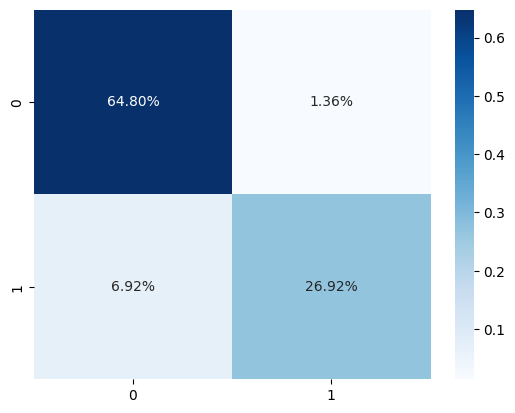

In [12]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt=".2%", cmap="Blues")